In [29]:
# Adapted from https://github.com/mvsoliveira/IBERTpy

#Basic imports
import csv
import matplotlib.ticker as ticker
import os, re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib as mpl
print("Using matplotlib:", mpl.__version__)
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import operator as op
from matplotlib.colors import ListedColormap


Using matplotlib: 3.3.4


In [17]:
# functions to generate the mask over the eye diagram
def get_mb(two_points):
    m = np.true_divide(*reversed([np.subtract(*s) for s in zip(*two_points)]))
    b = two_points[0][1] - m * two_points[0][0]
    return [m,b]

def gen_mask(size,two_points,operator, mask=[]):
    [m, b] = get_mb(two_points)
    if mask ==[]:
        mask = np.ones(list(reversed(size)), dtype=bool)
    for (y,x), value in np.ndenumerate(mask):
        mask[y][x] &= operator(y,m*x+b)
    return mask

def plot_mask(mask):
    plt.figure(num=None, figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k')
    plt.imshow(mask, interpolation='none', vmin=0, vmax=1, aspect='auto', alpha=1)
    plt.show()

def gen_decagon_mask(size, x1n, x2n, x3n, y1n, y2n):
    xm = size[0]
    ym = size[1]
    x1 = int(round(x1n * xm))
    x2 = int(round(x2n * xm))
    x3 = int(round(x3n * xm))
    y1 = int(round(y1n * ym))
    y2 = int(round(y2n * ym))
    yhalf = int(round(0.5 * ym))
    points = [[x1, yhalf], [x2, ym - y2], [x3, ym - y1], [xm - x3, ym - y1], [xm - x2, ym - y2], [xm - x1, yhalf], [xm - x2, y2], [xm - x3, y1], [x3, y1], [x2, y2]]
    pairs = zip(points, points[1:] + [points[0]])
    ops = [op.lt, op.lt, op.lt, op.lt, op.lt, op.gt, op.gt, op.gt, op.gt, op.gt]
    mask = []
    for (p, o) in zip(pairs, ops):
        mask = gen_mask(size, p, o, mask)
        # plot_mask(mask)
    return mask

# function for getting eye data
def get_eye(scan_list):
    eyedata = False
    yticks = []
    img = []
    for row in scan_list:
        if eyedata:
            yticks.append(row[0])
            img.append(row[1:])
        else:
            xticks = row[1:]
            eyedata = True
    img = [[float(y) for y in x] for x in img]

    xticks = [int(x) for x in xticks]
    yticks = [int(y) for y in yticks]
    return [img, xticks, yticks]

# function for calculating x-y axis ranges in a such way that ticks is in the center of each entry
def get_extent(xticks_n,yticks_r):
    xmin = xticks_n[0]
    xmax = xticks_n[-1]
    xstep = (xmax-xmin)/(len(xticks_n)-1)
    xmin_e = xmin-xstep/2
    xmax_e = xmax+xstep/2
    ymin = yticks_r[0]
    ymax = yticks_r[-1]
    ystep = (ymax-ymin)/(len(yticks_r)-1)
    ymin_e = ymin-ystep/2
    ymax_e = ymax+ystep/2
    return [xmin_e, xmax_e, ymin_e, ymax_e]

In [24]:
def eyescan_plot(filename_i, filename_o, minlog10ber, eye_height, eye_width, maskPoints=(), colorbar=True, xaxis=True, yaxis=True, xticks_f=[],yticks_f=[]):
    # opens the file
    with open(filename_i, 'r') as f:
            reader = csv.reader(f)
            scan_list = list(reader)
            
    # getting eye data
    [img, xticks, yticks] = get_eye(scan_list)
    
    # defining the mask
    if not maskPoints == ():
        size = [len(xticks), len(yticks)]
        mask = gen_decagon_mask(size, *maskPoints)

        # testing Mask
        Passed = True
        for (y, x), value in np.ndenumerate(mask):
            if mask[y][x]:
                Passed &= img[y][x] < 1e-7
        
            # creating color map
        if Passed:
            color = 'green'
        else:
            color = 'red'
        cmap = mpl.colors.LinearSegmentedColormap.from_list('my_cmap', ['white', color], 2)
        my_cmap = cmap(np.arange(cmap.N))
        my_cmap[:, -1] = np.linspace(0, 1, cmap.N)
        my_cmap = ListedColormap(my_cmap)
        
    # Generating, formating plot    
    plt.figure(num=None, figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k')
    xticks_n = [float(x)/(2*xticks[-1]) for x in xticks]
    yticks_r = [y for y in reversed(yticks)]
    myplot = plt.imshow(np.log10(img),interpolation='none', vmin = minlog10ber, vmax = 0, aspect='auto', extent = get_extent(xticks_n,yticks_r), cmap = 'jet')
    if not maskPoints == ():
        plt.imshow(mask, interpolation='none', vmin=0, vmax=1, aspect='auto',
                   extent=get_extent(xticks_n, yticks_r), cmap=my_cmap, origin='lower', alpha=0.9)
    if xaxis:
        if not yticks:
            plt.xticks(xticks_n)
        else:                             
            plt.xticks(xticks_f)
    if yaxis:
        if not yticks:
            plt.yticks(yticks_r)
        else:                             
            plt.yticks(yticks_f)
    else:
        plt.yticks([])
    
    plt.xlabel(r"Unit interval", fontsize = 14); 
    plt.ylabel(r"Voltage [codes]", fontsize = 14); 
    # formating colorbar axis
    if colorbar:
        def fmt(x, pos):
            return '$10^{{{0:d}}}$'.format(x)        
        plt.colorbar(myplot, format=ticker.FuncFormatter(fmt), ticks=range(minlog10ber,1,1))
        
    # adding eye height and width text to plot
    plt.text(-0.5, -150, "Eye height: " + str(eye_height) + "  Eye width: " + str(eye_width))
    
    # saving plot
#     plt.savefig(filename_o,bbox_inches='tight')
    # showing plot if needed
    plt.show()
    plt.close()

<ipython-input-17-0037304db391>:9: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if mask ==[]:


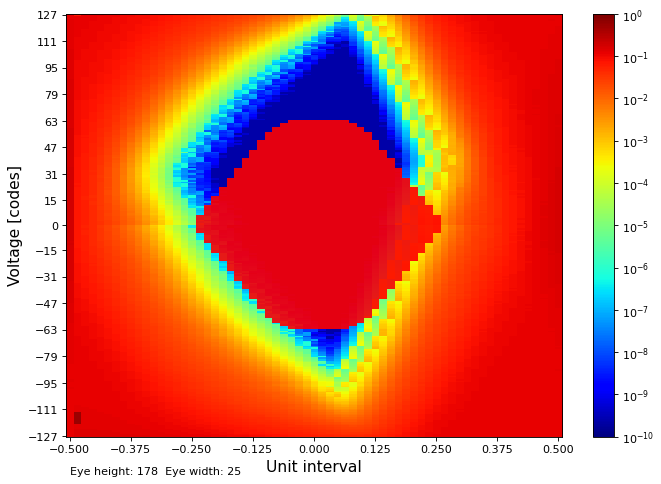

In [37]:
# Set input and output file names
path_to_plots = "finalcode/gearshift/EoS/testing/plots/"

filename = "eyeDataprescale9defaultConfig.csv"
i = path_to_plots + filename
o = path_to_plots + "eyeDiagramWithoutMask" + ".png"

# Calculate eye width and height
df = pd.read_csv(i)

threshold = 10**-9
y_range = range(127, -128, -1)
x_range = (range(-32,33,1))

eye_width = 0
width_tick = 0
for y_tick in y_range:
    row = df.iloc[y_tick+127] < threshold
    row_counts = row.value_counts()
    if len(row_counts) > 1:
        width = row.value_counts()[1]
        if width > eye_width:
            eye_width = width
            width_tick = y_tick

eye_height = 0
height_tick = 0
for x_tick in x_range:
    col = df.iloc[:,x_tick+32] < threshold
    col_counts = col.value_counts()
    if len(col_counts) > 1:
        height = col.value_counts()[1]
        if height > eye_height:
            eye_height = height
            height_tick = x_tick

# Set the mask measurements
# Mask that fails
# mask_x1x2x3y1y2 = (0.25, 0.4, 0.45, 0.25, 0.28)
# Mask that passes
# mask_x1x2x3y1y2 = (0.35, 0.45, 0.55, 0.3, 0.35)
# Leave the mask empty to not plot a mask
mask_x1x2x3y1y2 = ()

# Set the minimum BER
minlog10ber = -10

yticks = list(range(-127,0,16))+[0]+list(range(127,0,-16))[-1::-1]
xticks = list(np.arange(-0.5,0.625,0.125))
eyescan_plot(i, o, minlog10ber, eye_height, eye_width, maskPoints=mask_x1x2x3y1y2, colorbar=True, xaxis=True, yaxis=True, xticks_f=xticks, yticks_f=yticks)


In [15]:
mask_x1x2x3y1y2 = (0.25, 0.4, 0.45, 0.25, 0.28)
print(type(mask_x1x2x3y1y2))

<class 'tuple'>


In [16]:
mask = ()
print(mask)
if mask == ():
    print("Empty")
else:
    print("not empty")
mask = (1,2,3,4)
if mask == ():
    print("Empty")
else:
    print("not empty")

()
Empty
not empty
